In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import pretrained_microscopy_models as pmm
import torch.utils.model_zoo as model_zoo
import warnings
import os
import pandas as pd
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random
import datetime

# Suppress the PyTorch deprecation warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
image_path = 'dss_2205/image/'
data_path = 'dss_2205/hardness_table.csv'

In [18]:
# image augmentations
train_augmentations = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225])
])

test_augmentations = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225])
])

In [19]:
# dataset perparation
# class IM2PROPDataset(Dataset):
#     def __init__(self, csv_data, image_dir, transform=None):
#         self.data = csv_data.reset_index(drop=True)
#         self.img_dir = image_dir
#         self.transform = transform

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         img_name = self.data.iloc[idx, 0]
#         img_path = os.path.join(self.img_dir, f"{img_name}.png")
#         target = self.data.iloc[idx, 2]


#         image = Image.open(img_path).convert("RGB")
#         if self.transform:
#             image = self.transform(image)
        
#         target = torch.tensor(target, dtype=torch.float32)
#         return image, target

In [20]:
# dataset perparation
class IM2PROPDataset(Dataset):
    """
    Tiles each 768x768 image into 4 patches of 384x384 (TL, TR, BL, BR).
    Target value is copied to all patches.
    """
    # 4 quadrants (left, top, right, bottom)
    # using this to increase dataset size
    BOXES = [
        (0,   0,   384, 384),  # top-left  -> patch_id 0
        (384, 0,   768, 384),  # top-right -> patch_id 1
        (0,   384, 384, 768),  # bottom-left -> patch_id 2
        (384, 384, 768, 768),  # bottom-right-> patch_id 3
    ]

    def __init__(self, csv_data, image_dir, transform=None, return_info=False):
        # Expect columns: image_id, avg_hardness, avg_hardness_round
        self.data = csv_data.reset_index(drop=True)
        self.img_dir = image_dir
        self.transform = transform
        self.return_info = return_info  # if True, also return (img_name, patch_id)

    def __len__(self):
        # 4 tiles per base image
        return len(self.data) * 4

    def __getitem__(self, idx):
        base_idx = idx // 4        # which base image
        patch_id = idx % 4         # which quadrant

        img_name = self.data.iloc[base_idx, 0]  # 'image_id'
        target   = self.data.iloc[base_idx, 2]  # 'avg_hardness_round'
        img_path = os.path.join(self.img_dir, f"{img_name}.png")

        image = Image.open(img_path).convert("RGB")
        tile  = image.crop(self.BOXES[patch_id])  # 384x384

        if self.transform:
            tile = self.transform(tile)

        target = torch.tensor(target, dtype=torch.float32)

        if self.return_info:
            return tile, target, (img_name, patch_id)
        return tile, target

In [21]:
df = pd.read_csv(data_path)

random_state = random.randint(0, 10000)

train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=random_state)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=random_state)

train_dataset = IM2PROPDataset(train_df, image_dir=image_path, transform=train_augmentations)
val_dataset = IM2PROPDataset(val_df, image_dir=image_path, transform=test_augmentations)
test_dataset = IM2PROPDataset(test_df, image_dir=image_path, transform=test_augmentations)

print(f"Train images: {len(train_dataset)}")
print(f"Val images  : {len(val_dataset)}")
print(f"Test images : {len(test_dataset)}")
print(f"Total       : {len(train_dataset)+len(val_dataset)+len(test_dataset)}")

Train images: 152
Val images  : 40
Test images : 48
Total       : 240


In [22]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [23]:
# --- 1. Define the Custom Regression Head (Decoder) ---
class RegressionHead(nn.Module):
    """
    The decoder part of the model, which performs aggregation and
    final dimensionality reduction from the 2048 feature channels to a single scalar.
    """
    def __init__(self, final_output_dim=1):
        super().__init__()
        
        # Spatial Aggregation: Global Average Pooling (GAP)
        # Input: [B, 2048, H, W] -> Output: [B, 2048, 1, 1]
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Channel-wise Dimensionality Reduction: Linear Layers
        self.regressor = nn.Sequential(
            # Input size is 2048 (from GAP)
            nn.Linear(2048, 1024), 
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(1024, 512), 
            nn.BatchNorm1d(512),
            nn.ReLU(),
            # nn.Dropout(0.5),

            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Linear(128, final_output_dim)  # Final output layer
        )

    def forward(self, x):
        # x shape: [B, 2048, H, W]
        x = self.avgpool(x)       # Shape: [B, 2048, 1, 1]
        x = torch.flatten(x, 1)   # Shape: [B, 2048] (The latent feature vector)
        output = self.regressor(x)
        
        return output

# --- 2. Define the Complete Model Wrapper ---
class MicroNetRegressor(nn.Module):
    """
    Combines the pre-trained ResNet encoder features with the new Regression Head.
    """
    def __init__(self, pre_trained_base_model):
        super().__init__()
        
        # --- ENCODER (The pre-trained feature extractor) ---
        # We explicitly assemble the layers that constitute the ResNet feature backbone.
        # This excludes the original 'avgpool' and 'fc' classification layers.
        self.encoder_features = nn.Sequential(
            pre_trained_base_model.conv1, 
            pre_trained_base_model.bn1, 
            pre_trained_base_model.relu, 
            pre_trained_base_model.maxpool, 
            pre_trained_base_model.layer1, 
            pre_trained_base_model.layer2, 
            pre_trained_base_model.layer3, 
            pre_trained_base_model.layer4
        )
        
        # --- DECODER / REGRESSION HEAD (The new, trainable part) ---
        self.regression_head = RegressionHead(final_output_dim=1)

    def forward(self, x):
        # 1. Pass input through the pre-trained encoder
        x = self.encoder_features(x)  # Output is the deep feature map: [B, 2048, H, W]
        
        # 2. Pass feature map through the custom head for regression
        output = self.regression_head(x) # Output is the scalar prediction: [B, 1]
        
        return output
    
# --- 3. Model Initialization and Loading ---

# Configuration
encoder_name = 'resnet50'
weights_source = 'micronet'

print(f"Loading {encoder_name} architecture...")
# Initialize the base PyTorch ResNet-50 model (un-initialized, as we load custom weights later)
# Using weights=None to comply with the new PyTorch API
base_model = torch.hub.load('pytorch/vision:v0.10.0', encoder_name, weights=None)

# Get the URL for the MicroNet pre-trained weights
url = pmm.util.get_pretrained_microscopynet_url(encoder=encoder_name, encoder_weights=weights_source)

print(f"Loading MicroNet weights from: {url}")
# Load the MicroNet state dictionary into the ResNet-50 model
base_model.load_state_dict(model_zoo.load_url(url))

# 4. Instantiate the Final Regression Model
model_regressor = MicroNetRegressor(pre_trained_base_model=base_model)
model_regressor.eval() # Set model to evaluation mode (important for BN layers)
model_regressor = model_regressor.to(device)

# --- 5. Optional: Freeze the Encoder Layers ---
# Freeze all encoder weights to only train the new regression head initially
for name, param in model_regressor.named_parameters():
    if name.startswith('encoder_features'):
        param.requires_grad = False
    
# Check which parameters are trainable
total_params = sum(p.numel() for p in model_regressor.parameters())
trainable_params = sum(p.numel() for p in model_regressor.parameters() if p.requires_grad)

print("\n--- Model Summary ---")
print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters (Regression Head): {trainable_params:,}")
print(f"Encoder Layers Frozen: {total_params - trainable_params:,}")

Loading resnet50 architecture...
Loading MicroNet weights from: https://nasa-public-data.s3.amazonaws.com/microscopy_segmentation_models/resnet50_pretrained_microscopynet_v1.1.pth.tar


Using cache found in /home/jay/.cache/torch/hub/pytorch_vision_v0.10.0



--- Model Summary ---
Total Parameters: 26,200,129
Trainable Parameters (Regression Head): 2,692,097
Encoder Layers Frozen: 23,508,032


In [24]:
# # =========================
# # Regression head (GAP -> MLP -> scalar)
# # =========================
# class RegressionHead(nn.Module):
#     def __init__(self, in_ch=2048, final_output_dim=1):
#         super().__init__()
#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.regressor = nn.Sequential(
#             nn.Linear(in_ch, 1024),
#             nn.BatchNorm1d(1024),
#             nn.ReLU(),
#             nn.Dropout(0.5),

#             nn.Linear(1024, 512),
#             nn.BatchNorm1d(512),
#             nn.ReLU(),

#             nn.Linear(512, 128),
#             nn.BatchNorm1d(128),
#             nn.ReLU(),

#             nn.Linear(128, final_output_dim),
#         )

#     def forward(self, x):
#         x = self.avgpool(x)      # [B, 2048, 1, 1]
#         x = torch.flatten(x, 1)  # [B, 2048]
#         return self.regressor(x) # [B, 1]


# # =========================
# # Full model: ResNet encoder -> RegressionHead
# # =========================
# class MicroNetRegressor(nn.Module):
#     def __init__(self, pre_trained_base_model):
#         super().__init__()
#         self.encoder_features = nn.Sequential(
#             pre_trained_base_model.conv1,
#             pre_trained_base_model.bn1,
#             pre_trained_base_model.relu,
#             pre_trained_base_model.maxpool,
#             pre_trained_base_model.layer1,
#             pre_trained_base_model.layer2,
#             pre_trained_base_model.layer3,
#             pre_trained_base_model.layer4,
#         )
#         self.regression_head = RegressionHead(final_output_dim=1)

#     def forward(self, x):
#         feats = self.encoder_features(x)
#         return self.regression_head(feats)


# # =========================
# # Build model with your MicroNet weights
# # =========================
# def build_micronet_model(device):
#     encoder_name = 'resnet50'
#     weights_source = 'micronet'

#     print(f"Loading {encoder_name} architecture...")
#     base_model = torch.hub.load('pytorch/vision:v0.10.0', encoder_name, weights=None)

#     # --- Get MicroNet pretrained weights ---
#     url = pmm.util.get_pretrained_microscopynet_url(encoder=encoder_name, encoder_weights=weights_source)
#     print(f"Loading MicroNet weights from: {url}")
#     base_model.load_state_dict(model_zoo.load_url(url))

#     # --- Wrap with regression head ---
#     model_regressor = MicroNetRegressor(pre_trained_base_model=base_model)
#     model_regressor = model_regressor.to(device)
#     model_regressor.eval()
#     print("✅ MicroNetRegressor initialized and ready.")
#     return model_regressor


# # =========================
# # Grad-CAM for visualization
# # =========================
# class GradCAM:
#     def __init__(self, model):
#         self.model = model
#         self.model.eval()
#         self._acts = None
#         self._grads = None

#         self.h_fwd = self.model.encoder_features.register_forward_hook(self._save_acts)
#         try:
#             self.h_bwd = self.model.encoder_features.register_full_backward_hook(self._save_grads)
#         except AttributeError:
#             self.h_bwd = self.model.encoder_features.register_backward_hook(self._save_grads)

#     def _save_acts(self, module, inp, out):
#         self._acts = out

#     def _save_grads(self, module, grad_in, grad_out):
#         self._grads = grad_out[0]

#     @torch.no_grad()
#     def _normalize_cam(self, cam):
#         B = cam.shape[0]
#         cam = cam.view(B, -1)
#         mx = cam.max(dim=1, keepdim=True).values + 1e-8
#         cam = (cam / mx).view(B, 1, *self._acts.shape[-2:])
#         return cam

#     def __call__(self, x, up_to_size=None):
#         self.model.zero_grad(set_to_none=True)
#         with torch.enable_grad():
#             y = self.model(x)
#             score = y.sum()

#         score.backward(retain_graph=True)

#         acts  = self._acts
#         grads = self._grads
#         weights = grads.mean(dim=(2,3), keepdim=True)
#         cam = (weights * acts).sum(dim=1, keepdim=True)
#         cam = F.relu(cam)
#         cam = self._normalize_cam(cam)

#         if up_to_size is None:
#             up_to_size = x.shape[-2:]
#         cam_up = F.interpolate(cam, size=up_to_size, mode="bilinear", align_corners=False)
#         return cam_up

#     def remove(self):
#         self.h_fwd.remove()
#         self.h_bwd.remove()

# model_regressor = build_micronet_model(device)

# # x: a batch [B,3,H,W] in [0,1] on device
# # preds = model(x)          # forward
# # cam   = GradCAM(model)(x) # [B,1,H,W] heatmaps upsampled back to input size



In [25]:
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_regressor.parameters()), lr=1e-3)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)  # optional

In [26]:
# --- 3. Training Loop ---
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    
    for images, targets in tqdm(dataloader, desc="Training", leave=False):
        images, targets = images.to(device), targets.to(device).unsqueeze(1)  # [B, 1]
        
        optimizer.zero_grad()
        outputs = model(images)              # forward pass -> [B, 1]
        loss = criterion(outputs, targets)   # MSE loss
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss


def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    preds, trues = [], []

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Validation", leave=False):
            images, targets = images.to(device), targets.to(device).unsqueeze(1)
            outputs = model(images)
            
            loss = criterion(outputs, targets)
            running_loss += loss.item() * images.size(0)
            
            preds.append(outputs.cpu().numpy())
            trues.append(targets.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    preds_scaled = np.concatenate(preds).squeeze()
    trues_scaled = np.concatenate(trues).squeeze()

    mse = np.mean((preds_scaled - trues_scaled) ** 2)
    mae = np.mean(np.abs(preds_scaled - trues_scaled))
    rmse = np.sqrt(mse)

    return epoch_loss, mae, mse, rmse


Epoch [1/50]


Train Loss: 1.5565 | Val Loss: 1.4440 | Val MAE: 1.9440 | Val MSE: 3.8688 | Val RMSE: 1.9669
✅ Saved new best model

Epoch [2/50]


Train Loss: 0.4537 | Val Loss: 0.8018 | Val MAE: 1.2676 | Val MSE: 1.8931 | Val RMSE: 1.3759
✅ Saved new best model

Epoch [3/50]


Train Loss: 0.0880 | Val Loss: 0.0898 | Val MAE: 0.3412 | Val MSE: 0.1796 | Val RMSE: 0.4238
✅ Saved new best model

Epoch [4/50]


Train Loss: 0.0373 | Val Loss: 0.0135 | Val MAE: 0.1382 | Val MSE: 0.0270 | Val RMSE: 0.1644
✅ Saved new best model

Epoch [5/50]


Train Loss: 0.0226 | Val Loss: 0.0191 | Val MAE: 0.1664 | Val MSE: 0.0382 | Val RMSE: 0.1954

Epoch [6/50]


Train Loss: 0.0289 | Val Loss: 0.1181 | Val MAE: 0.3368 | Val MSE: 0.3201 | Val RMSE: 0.5658

Epoch [7/50]


Train Loss: 0.0392 | Val Loss: 0.0385 | Val MAE: 0.2624 | Val MSE: 0.0770 | Val RMSE: 0.2776

Epoch [8/50]


Train Loss: 0.0236 | Val Loss: 0.0234 | Val MAE: 0.1932 | Val MSE: 0.0467 | Val RMSE: 0.2162

Epoch [9/50]


Train Loss: 0.0114 | Val Loss: 0.0155 | Val MAE: 0.1539 | Val MSE: 0.0310 | Val RMSE: 0.1760

Epoch [10/50]


Train Loss: 0.0173 | Val Loss: 0.0239 | Val MAE: 0.1944 | Val MSE: 0.0478 | Val RMSE: 0.2186

Epoch [11/50]


Train Loss: 0.0179 | Val Loss: 0.0053 | Val MAE: 0.0807 | Val MSE: 0.0106 | Val RMSE: 0.1027
✅ Saved new best model

Epoch [12/50]


Train Loss: 0.0192 | Val Loss: 0.0112 | Val MAE: 0.1148 | Val MSE: 0.0224 | Val RMSE: 0.1497

Epoch [13/50]


Train Loss: 0.0146 | Val Loss: 0.0061 | Val MAE: 0.0939 | Val MSE: 0.0122 | Val RMSE: 0.1106

Epoch [14/50]


Train Loss: 0.0116 | Val Loss: 0.0091 | Val MAE: 0.1048 | Val MSE: 0.0182 | Val RMSE: 0.1350

Epoch [15/50]


Train Loss: 0.0233 | Val Loss: 0.0440 | Val MAE: 0.2617 | Val MSE: 0.0880 | Val RMSE: 0.2967

Epoch [16/50]


Train Loss: 0.0219 | Val Loss: 0.0548 | Val MAE: 0.3008 | Val MSE: 0.1095 | Val RMSE: 0.3310

Epoch [17/50]


Train Loss: 0.0332 | Val Loss: 0.0841 | Val MAE: 0.3582 | Val MSE: 0.1682 | Val RMSE: 0.4102

Epoch [18/50]


Train Loss: 0.0265 | Val Loss: 0.0054 | Val MAE: 0.0834 | Val MSE: 0.0108 | Val RMSE: 0.1038

Epoch [19/50]


Train Loss: 0.0176 | Val Loss: 0.0311 | Val MAE: 0.2233 | Val MSE: 0.0622 | Val RMSE: 0.2494

Epoch [20/50]


Train Loss: 0.0148 | Val Loss: 0.0117 | Val MAE: 0.1315 | Val MSE: 0.0234 | Val RMSE: 0.1531

Epoch [21/50]


Train Loss: 0.0146 | Val Loss: 0.0399 | Val MAE: 0.2499 | Val MSE: 0.0799 | Val RMSE: 0.2826

Epoch [22/50]


Train Loss: 0.0140 | Val Loss: 0.0049 | Val MAE: 0.0786 | Val MSE: 0.0098 | Val RMSE: 0.0988
✅ Saved new best model

Epoch [23/50]


Train Loss: 0.0128 | Val Loss: 0.0082 | Val MAE: 0.1137 | Val MSE: 0.0164 | Val RMSE: 0.1280

Epoch [24/50]


Train Loss: 0.0177 | Val Loss: 0.0130 | Val MAE: 0.1358 | Val MSE: 0.0260 | Val RMSE: 0.1611

Epoch [25/50]


Train Loss: 0.0091 | Val Loss: 0.0086 | Val MAE: 0.1105 | Val MSE: 0.0172 | Val RMSE: 0.1311

Epoch [26/50]


Train Loss: 0.0068 | Val Loss: 0.0106 | Val MAE: 0.1273 | Val MSE: 0.0213 | Val RMSE: 0.1458

Epoch [27/50]


Train Loss: 0.0093 | Val Loss: 0.0146 | Val MAE: 0.1600 | Val MSE: 0.0292 | Val RMSE: 0.1710

Epoch [28/50]


Train Loss: 0.0114 | Val Loss: 0.0113 | Val MAE: 0.1191 | Val MSE: 0.0226 | Val RMSE: 0.1503

Epoch [29/50]


Train Loss: 0.0131 | Val Loss: 0.0111 | Val MAE: 0.1187 | Val MSE: 0.0221 | Val RMSE: 0.1488

Epoch [30/50]


Train Loss: 0.0132 | Val Loss: 0.0040 | Val MAE: 0.0717 | Val MSE: 0.0080 | Val RMSE: 0.0893
✅ Saved new best model

Epoch [31/50]


Train Loss: 0.0153 | Val Loss: 0.0318 | Val MAE: 0.2200 | Val MSE: 0.0637 | Val RMSE: 0.2523

Epoch [32/50]


Train Loss: 0.0139 | Val Loss: 0.0082 | Val MAE: 0.1075 | Val MSE: 0.0165 | Val RMSE: 0.1283

Epoch [33/50]


Train Loss: 0.0157 | Val Loss: 0.0083 | Val MAE: 0.1096 | Val MSE: 0.0165 | Val RMSE: 0.1286

Epoch [34/50]


Train Loss: 0.0138 | Val Loss: 0.0109 | Val MAE: 0.1344 | Val MSE: 0.0217 | Val RMSE: 0.1473

Epoch [35/50]


Train Loss: 0.0062 | Val Loss: 0.0196 | Val MAE: 0.1721 | Val MSE: 0.0391 | Val RMSE: 0.1978

Epoch [36/50]


Train Loss: 0.0084 | Val Loss: 0.0128 | Val MAE: 0.1433 | Val MSE: 0.0257 | Val RMSE: 0.1603

Epoch [37/50]


Train Loss: 0.0081 | Val Loss: 0.0148 | Val MAE: 0.1605 | Val MSE: 0.0296 | Val RMSE: 0.1721

Epoch [38/50]


Train Loss: 0.0101 | Val Loss: 0.0036 | Val MAE: 0.0706 | Val MSE: 0.0073 | Val RMSE: 0.0853
✅ Saved new best model

Epoch [39/50]


Train Loss: 0.0122 | Val Loss: 0.0146 | Val MAE: 0.1582 | Val MSE: 0.0292 | Val RMSE: 0.1710

Epoch [40/50]


Train Loss: 0.0072 | Val Loss: 0.0089 | Val MAE: 0.1178 | Val MSE: 0.0179 | Val RMSE: 0.1337

Epoch [41/50]


Train Loss: 0.0104 | Val Loss: 0.0256 | Val MAE: 0.2078 | Val MSE: 0.0513 | Val RMSE: 0.2264

Epoch [42/50]


Train Loss: 0.0110 | Val Loss: 0.0190 | Val MAE: 0.1838 | Val MSE: 0.0380 | Val RMSE: 0.1950

Epoch [43/50]


Train Loss: 0.0128 | Val Loss: 0.0217 | Val MAE: 0.1949 | Val MSE: 0.0434 | Val RMSE: 0.2084

Epoch [44/50]


Train Loss: 0.0072 | Val Loss: 0.0087 | Val MAE: 0.1201 | Val MSE: 0.0173 | Val RMSE: 0.1315

Epoch [45/50]


Train Loss: 0.0060 | Val Loss: 0.0082 | Val MAE: 0.1185 | Val MSE: 0.0165 | Val RMSE: 0.1284

Epoch [46/50]


Train Loss: 0.0042 | Val Loss: 0.0075 | Val MAE: 0.1102 | Val MSE: 0.0150 | Val RMSE: 0.1225

Epoch [47/50]


Train Loss: 0.0067 | Val Loss: 0.0038 | Val MAE: 0.0751 | Val MSE: 0.0076 | Val RMSE: 0.0872

Epoch [48/50]


Train Loss: 0.0126 | Val Loss: 0.0182 | Val MAE: 0.1754 | Val MSE: 0.0365 | Val RMSE: 0.1910

Epoch [49/50]


Train Loss: 0.0136 | Val Loss: 0.0205 | Val MAE: 0.1880 | Val MSE: 0.0409 | Val RMSE: 0.2023

Epoch [50/50]


Train Loss: 0.0117 | Val Loss: 0.0153 | Val MAE: 0.1612 | Val MSE: 0.0306 | Val RMSE: 0.1750

Training complete!


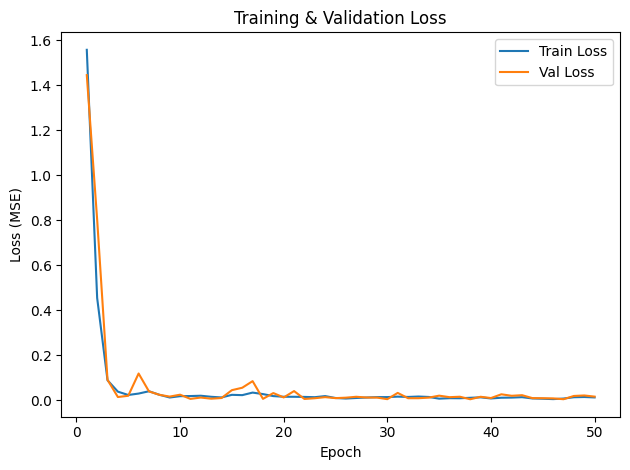

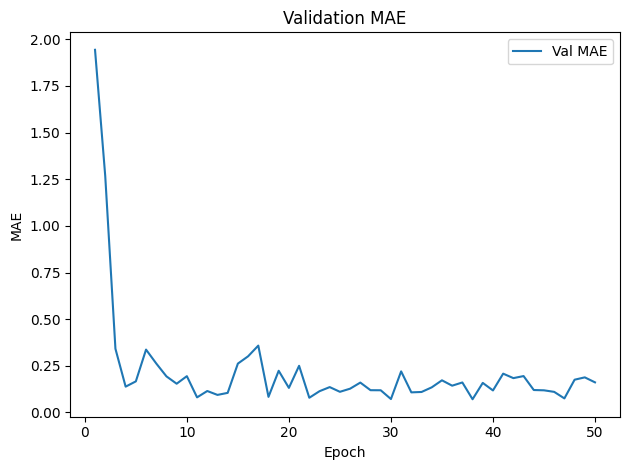

Saved plots: loss_curves.png, val_mae_curve.png


In [27]:
num_epochs = 50
best_val_loss = float('inf')
datetime_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
os.makedirs(f"runs/run_{datetime_str}", exist_ok=True)

# histories
hist_train_loss = []
hist_val_loss = []
hist_val_mae  = []

for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    
    train_loss = train_one_epoch(model_regressor, train_loader, optimizer, criterion, device)
    val_loss, val_mae, val_mse, rmse = validate_one_epoch(model_regressor, val_loader, criterion, device)
    
    # Step the scheduler
    # If you're using StepLR / CosineAnnealingLR:
    # scheduler.step()
    # If you're using ReduceLROnPlateau, use this instead:
    # scheduler.step(val_loss)
    
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val MAE: {val_mae:.4f} | Val MSE: {val_mse:.4f} | Val RMSE: {rmse:.4f}")

    # record history
    hist_train_loss.append(train_loss)
    hist_val_loss.append(val_loss)
    hist_val_mae.append(val_mae)
    
    # save best
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_regressor.state_dict(), f"runs/run_{datetime_str}/best_regression_model.pt")
        print("✅ Saved new best model")

print("\nTraining complete!")

# ---- Plot curves ----
# Loss curves
plt.figure()
plt.plot(range(1, num_epochs+1), hist_train_loss, label='Train Loss')
plt.plot(range(1, num_epochs+1), hist_val_loss, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training & Validation Loss')
plt.legend()
plt.tight_layout()
plt.savefig(f'runs/run_{datetime_str}/loss_curves.png', dpi=200)
plt.show()

# (Optional) MAE curve
plt.figure()
plt.plot(range(1, num_epochs+1), hist_val_mae, label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Validation MAE')
plt.legend()
plt.tight_layout()
plt.savefig(f'runs/run_{datetime_str}/val_mae_curve.png', dpi=200)
plt.show()

print("Saved plots: loss_curves.png, val_mae_curve.png")


Testing: 100%|██████████| 12/12 [00:00<00:00, 27.00it/s]



--- Test Results ---
MSE : 0.0282
MAE : 0.0942
RMSE  : 0.1679


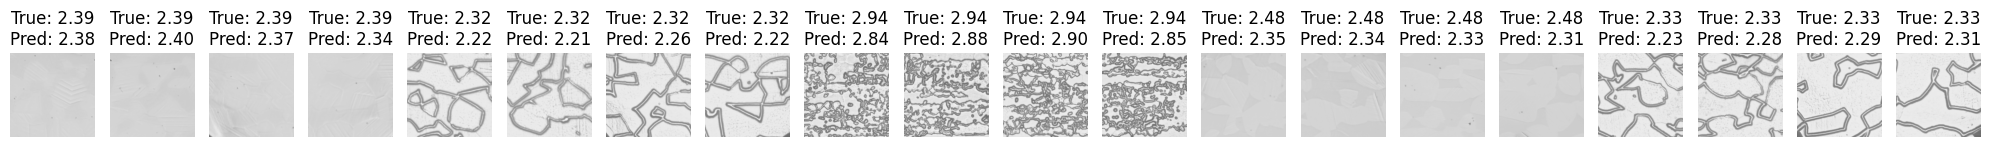

In [28]:
# Load model
model_regressor.load_state_dict(torch.load(f"runs/run_{datetime_str}/best_regression_model.pt", map_location=device))
model_regressor.to(device)
model_regressor.eval()  # VERY IMPORTANT for inference

def test_model(model, dataloader, device):
    model.eval()
    preds, trues, imgs = [], [], []

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Testing"):
            images, targets = images.to(device), targets.to(device).unsqueeze(1)
            outputs = model(images)

            preds.append(outputs.cpu().numpy())
            trues.append(targets.cpu().numpy())
            imgs.append(images.cpu().numpy())  # save image batch

    preds_scaled = np.concatenate(preds).squeeze()
    trues_scaled = np.concatenate(trues).squeeze()
    imgs_np = np.concatenate(imgs)

    mse = np.mean((preds_scaled - trues_scaled) ** 2)
    mae = np.mean(np.abs(preds_scaled - trues_scaled))
    rmse = np.sqrt(mse)

    print("\n--- Test Results ---")
    print(f"MSE : {mse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"RMSE  : {rmse:.4f}")

    return preds_scaled, trues_scaled, imgs_np


# Run test
preds, trues, imgs = test_model(model_regressor, test_loader, device)

# --- Plot some results ---
num_samples = 20  # number of samples to display
plt.figure(figsize=(20, 10))

for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(np.transpose(imgs[i], (1, 2, 0)))
    plt.title(f"True: {trues[i]:.2f}\nPred: {preds[i]:.2f}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [29]:
# # ============================================
# # --- Load model ---
# # ============================================
# model_regressor.load_state_dict(
#     torch.load(f"runs/run_{datetime_str}/best_regression_model.pt", map_location=device)
# )
# model_regressor.to(device)
# model_regressor.eval()  # VERY IMPORTANT for inference


# # ============================================
# # --- Grad-CAM helper ---
# # ============================================
# gradcam = GradCAM(model_regressor)  # from your model code


# def show_gradcam_overlay(img_tensor, cam_tensor, alpha=0.45):
#     """
#     img_tensor: [3,H,W], values in [0,1]
#     cam_tensor: [1,H,W], values in [0,1]
#     """
#     import numpy as np
#     import matplotlib.pyplot as plt

#     img = img_tensor.detach().cpu().numpy().transpose(1, 2, 0)
#     cam = cam_tensor.detach().cpu().numpy()[0]

#     cmap = plt.get_cmap("jet")
#     cam_color = cmap(cam)[:, :, :3]
#     overlay = np.clip(alpha * cam_color + (1 - alpha) * img, 0, 1)
#     return img, cam, overlay


# # ============================================
# # --- Test function with Grad-CAM visualization ---
# # ============================================
# def test_model(model, dataloader, device, show_num=12, save_dir=None):
#     model.eval()
#     preds, trues, images_all = [], [], []

#     os.makedirs(save_dir, exist_ok=True) if save_dir else None

#     with torch.no_grad():
#         for images, targets in tqdm(dataloader, desc="Testing"):
#             images, targets = images.to(device), targets.to(device).unsqueeze(1)
#             outputs = model(images)

#             preds.append(outputs.cpu().numpy())
#             trues.append(targets.cpu().numpy())
#             images_all.append(images.cpu().numpy())

#     preds_scaled = np.concatenate(preds).squeeze()
#     trues_scaled = np.concatenate(trues).squeeze()
#     imgs_np = np.concatenate(images_all)

#     mse = np.mean((preds_scaled - trues_scaled) ** 2)
#     mae = np.mean(np.abs(preds_scaled - trues_scaled))
#     rmse = np.sqrt(mse)

#     print("\n--- Test Results ---")
#     print(f"MSE  : {mse:.4f}")
#     print(f"MAE  : {mae:.4f}")
#     print(f"RMSE : {rmse:.4f}")

#     # --- Show Grad-CAM for first few samples ---
#     model.eval()
#     x = torch.tensor(imgs_np[:show_num]).to(device)
#     cams = gradcam(x, up_to_size=x.shape[-2:])  # [B,1,H,W]

#     # --- Plot results in a clean grid (3 columns) ---
#     num_show = min(show_num, x.shape[0])
#     ncols = 3
#     nrows = int(np.ceil(num_show / ncols))

#     plt.figure(figsize=(12, 4 * nrows))

#     for i in range(num_show):
#         img, cam, overlay = show_gradcam_overlay(x[i].cpu(), cams[i].cpu())

#         # column 1: original
#         plt.subplot(nrows, ncols, i * ncols % (ncols * nrows) + 1)
#         plt.imshow(img)
#         plt.axis("off")
#         plt.title(f"True:{trues_scaled[i]:.2f}\nPred:{preds_scaled[i]:.2f}")

#         # column 2: heatmap
#         plt.subplot(nrows, ncols, i * ncols % (ncols * nrows) + 2)
#         plt.imshow(cam, cmap="jet")
#         plt.axis("off")
#         plt.title("Grad-CAM")

#         # column 3: overlay
#         plt.subplot(nrows, ncols, i * ncols % (ncols * nrows) + 3)
#         plt.imshow(overlay)
#         plt.axis("off")
#         plt.title("Overlay")

#         # --- Save overlays if requested ---
#         if save_dir:
#             plt.imsave(f"{save_dir}/sample_{i}_overlay.png", overlay)

#     plt.tight_layout()
#     plt.show()

#     return preds_scaled, trues_scaled, imgs_np


# # ============================================
# # --- Run test ---
# # ============================================
# preds, trues, imgs = test_model(
#     model_regressor,
#     test_loader,
#     device,
#     show_num=15,                        # number of Grad-CAM samples to show
#     save_dir=f"runs/run_{datetime_str}/gradcam_overlays"  # optional save folder
# )

# gradcam.remove()  # cleanup hooks


In [30]:
# A. Scale mismatch?
imgs, y = next(iter(train_loader))
with torch.no_grad():
    p = model_regressor(imgs.to(device)).cpu().squeeze()
print("targets range:", y.min().item(), y.max().item())   
print("preds   range:", p.min().item(), p.max().item())    # should be similar scale


targets range: 2.2219998836517334 2.868000030517578
preds   range: 2.2489678859710693 2.7807533740997314
